# Simulation in XY mode

We introduce here a new mode of interaction between the atoms driven by the dipole-dipole interaction. This mode is called the XY mode. The interaction hamiltonian of a system of $N$ qubits is now given by 

$$
H_{XY} = \frac{1}{2}\sum_{i<j} \frac{C_3}{R_{ij}^3}(\sigma^+_i \sigma^-_j + \sigma^-_i \sigma^+_j) 
$$

where $\sigma^{±} = (\sigma^x ± i\sigma^y)/2$, $R_{ij}$ is the distance between atom $i$ and atom $j$, and $C_3$ is a coefficient dependent on the device and taken to 3070 MHz $\cdot \mu m^{-3}$ for the `MockDevice`.

The final hamiltonian of the system is 

$$
H= \sum_{i=1}^N \frac{\hbar\Omega}{2} \sigma_i^x - \sum_{i=1}^N \frac{\hbar \delta}{2}  \sigma_i^z+H_{XY}.
\label{eq:XY_Hamiltonian}
$$

The Rydberg states involved are different from the ones of the Ising interaction, they are $|0\rangle = |62D_{3/2}, m_j=3/2 \rangle$ and $|1\rangle = |63P_{1/2}, m_j=1/2 \rangle$. 


More details on the XY mode can be found in the following reference: [Barredo et al. 2014](https://arxiv.org/pdf/1408.1055.pdf)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import qutip

import pulser
from pulser import Pulse, Sequence, Register
from pulser.simulation import Simulation
from pulser.devices import MockDevice

### Rabi oscillations of 1 atom

We start by showing Rabi oscillation in the XY mode in the case of a unique atom as shown in the figure 1 (c) of the [reference](https://arxiv.org/pdf/1408.1055.pdf). In a similar way as the Ising mode, the atom will oscillate between the two energy levels. The XY mode is only available in the `mw_global`channel. We initialize the register and instantiate the channel. 

In [2]:
coords = np.array([[0, 0]])
qubits = dict(enumerate(coords))

reg = Register(qubits)
seq = Sequence(reg, MockDevice)
seq.declare_channel('MW', 'mw_global')

We then add a simple constant rabi pulse of amplitude $2\pi \times 4.6$ MHz and run the simulation. The measurement is necessarily done in the `XY` basis.

Channel: MW
t: 0 | Initial targets: 0 | Phase Reference: 0.0 
t: 0->4000 | Pulse(Amp=28.9 rad/µs, Detuning=0 rad/µs, Phase=0) | Targets: 0

Measured in basis: XY


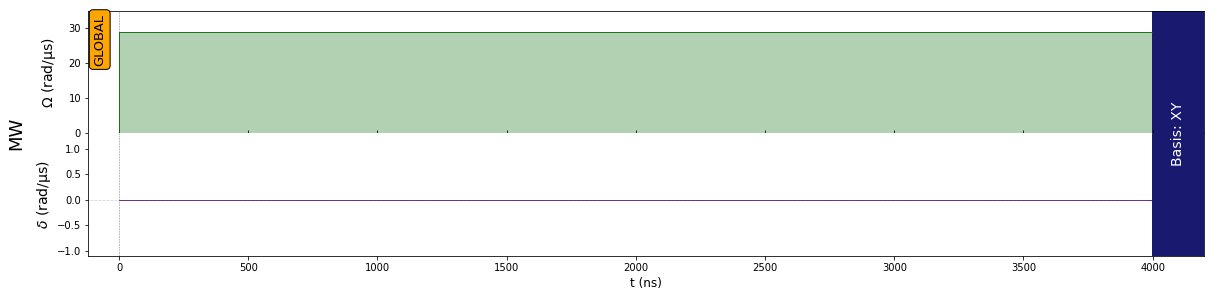

10.0%. Run time:   0.05s. Est. time left: 00:00:00:00
20.0%. Run time:   0.09s. Est. time left: 00:00:00:00
30.0%. Run time:   0.14s. Est. time left: 00:00:00:00
40.0%. Run time:   0.20s. Est. time left: 00:00:00:00
50.0%. Run time:   0.27s. Est. time left: 00:00:00:00
60.0%. Run time:   0.34s. Est. time left: 00:00:00:00
70.0%. Run time:   0.38s. Est. time left: 00:00:00:00
80.0%. Run time:   0.47s. Est. time left: 00:00:00:00
90.0%. Run time:   0.53s. Est. time left: 00:00:00:00
Total run time:   0.61s


In [3]:
simple_pulse = Pulse.ConstantPulse(4000, 2*np.pi*4.6, 0, 0)
seq.add(simple_pulse, 'MW')
seq.measure(basis='XY')

print(seq)
sim = Simulation(seq, sampling_rate=1)
seq.draw()

results = sim.run(progress_bar=True, nsteps=5000)

We plot the expectation of the excitation of the atom over the time.

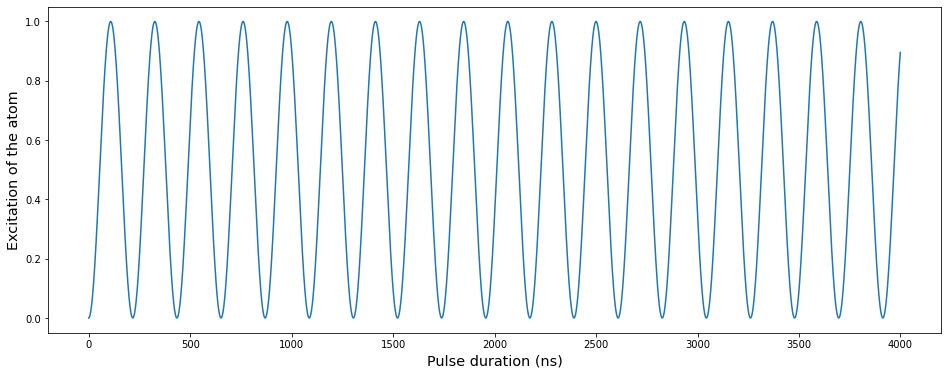

In [4]:
def magnetization(j, total_sites):
    prod = [qutip.qeye(2) for _ in range(total_sites)]
    prod[j] = (qutip.sigmaz() + qutip.qeye(2)) / 2
    return qutip.tensor(prod)

magn = magnetization(0, 1)
expectations = results.expect([magn])
plt.figure(figsize=[16, 6])
plt.plot(expectations[0])
plt.xlabel('Pulse duration (ns)', fontsize='x-large')
plt.ylabel('Excitation of the atom', fontsize='x-large')
plt.show()

### Spin chain of 3 atoms

We now simulate the free evolution of a spin chain of 3 atoms, starting with 1 excitation in the initial state $|100\rangle$ as shown in the figure 3 (c) of the [reference](https://arxiv.org/pdf/1408.1055.pdf). 

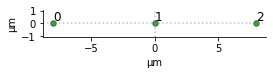

In [5]:
coords = np.array([[-8., 0], [0, 0], [8., 0]])
qubits = dict(enumerate(coords))

reg = Register(qubits)
seq = Sequence(reg, MockDevice)
seq.declare_channel('ch0', 'mw_global')
reg.draw()

simple_pulse = Pulse.ConstantPulse(7000, 0, 0, 0)
seq.add(simple_pulse, 'ch0')
seq.measure(basis='XY')

sim = Simulation(seq, sampling_rate=1)
sim.initial_state = np.array([0,0,0,1,0,0,0,0])
results = sim.run(nsteps=5000)

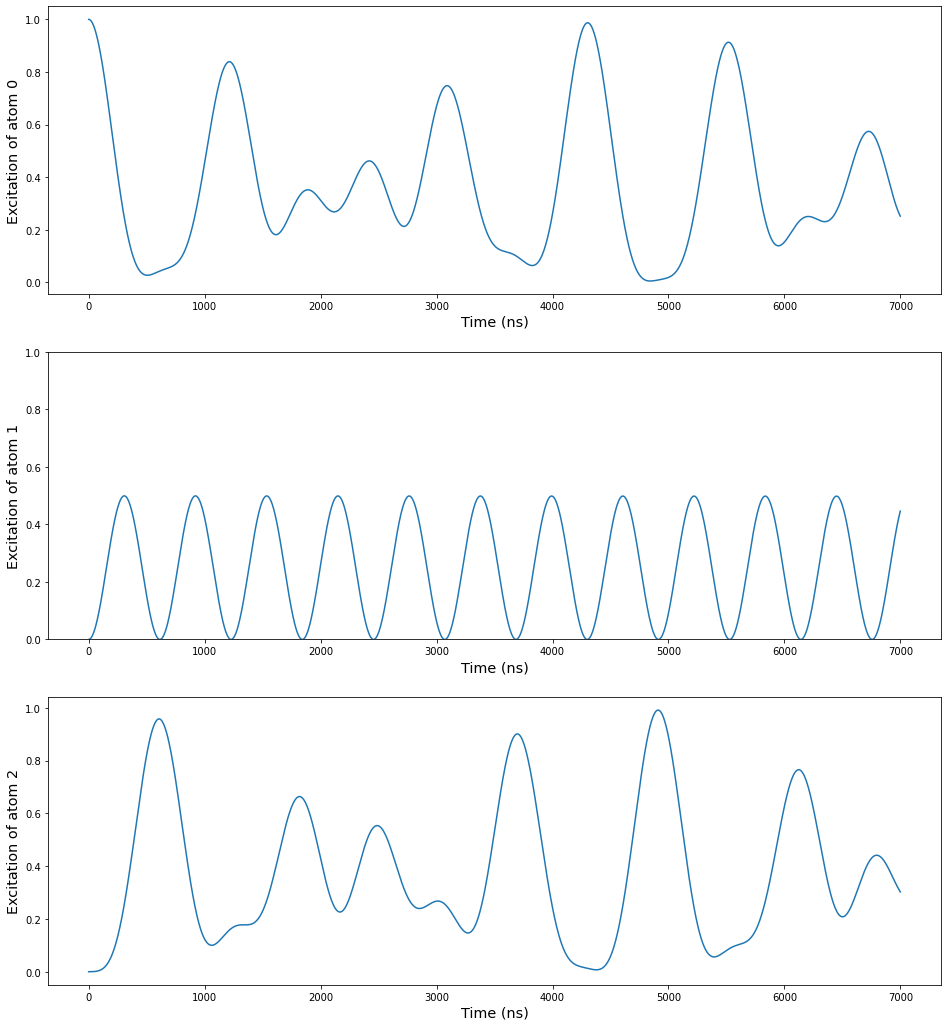

In [6]:
magn_list = [magnetization(j, 3) for j in range(3)]

expectations = results.expect(magn_list)

plt.figure(figsize=[16, 18])
plt.subplot(311)
plt.plot(expectations[0])
plt.ylabel('Excitation of atom 0', fontsize='x-large')
plt.xlabel('Time (ns)', fontsize='x-large')
plt.subplot(312)
plt.plot(expectations[1])
plt.ylabel('Excitation of atom 1', fontsize='x-large')
plt.xlabel('Time (ns)', fontsize='x-large')
plt.ylim([0, 1])
plt.subplot(313)
plt.plot(expectations[2])
plt.ylabel('Excitation of atom 2', fontsize='x-large')
plt.xlabel('Time (ns)', fontsize='x-large')
plt.show()

## External field and angular dependency

An external magnetic field can be added to the experiment, and will modify the hamiltonian. The XY Hamiltonian is then

$$
H_{XY} = \frac{1}{2}\sum_{i<j} \frac{C_3\:[1 - 3\:\text{cos}^2(\theta_{ij})]}{R_{ij}^3}(\sigma^+_i \sigma^-_j + \sigma^-_i \sigma^+_j) 
$$
where $\theta_{ij}$ is the angle between the vector of the two atoms and the external field as shown on the figure below.

<center>
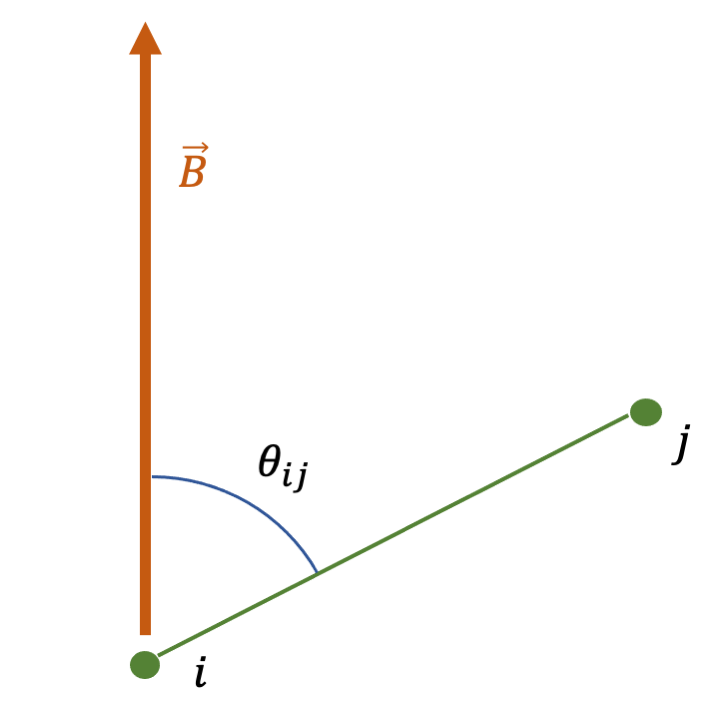
</center>

We add an external field along the Y axis, and we put the qubit 2 at the angle such that $\text{cos}^2(\theta_{12}) = 1/3$, and the interaction between the qubits 1 and 2 cancels out. This is done by the method `set_magnetic_field`from the `Sequence`.

This is the principle that enables to create [topological phases](https://science.sciencemag.org/content/365/6455/775) on long chain of atoms.

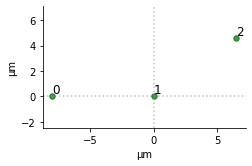

In [7]:
coords = np.array([[-1., 0], [0, 0], [np.sqrt(2/3), np.sqrt(1/3)]]) * 8.
qubits = dict(enumerate(coords))

reg = Register(qubits)
seq = Sequence(reg, MockDevice)
seq.declare_channel('ch0', 'mw_global')
seq.set_magnetic_field(0., 1., 0)
reg.draw()

We then simulate again the free evolution from the initial state $|100\rangle$. 

In [8]:
simple_pulse = Pulse.ConstantPulse(7000, 0, 0, 0)
seq.add(simple_pulse, 'ch0')
seq.measure(basis='XY')

sim = Simulation(seq, sampling_rate=1)
sim.initial_state = np.array([0,0,0,1,0,0,0,0])
results = sim.run(progress_bar=True, nsteps=5000)

10.0%. Run time:   0.07s. Est. time left: 00:00:00:00
20.0%. Run time:   0.16s. Est. time left: 00:00:00:00
30.0%. Run time:   0.26s. Est. time left: 00:00:00:00
40.0%. Run time:   0.35s. Est. time left: 00:00:00:00
50.0%. Run time:   0.44s. Est. time left: 00:00:00:00
60.0%. Run time:   0.56s. Est. time left: 00:00:00:00
70.0%. Run time:   0.63s. Est. time left: 00:00:00:00
80.0%. Run time:   0.76s. Est. time left: 00:00:00:00
90.0%. Run time:   0.84s. Est. time left: 00:00:00:00
Total run time:   0.91s


(0.0, 1.0)

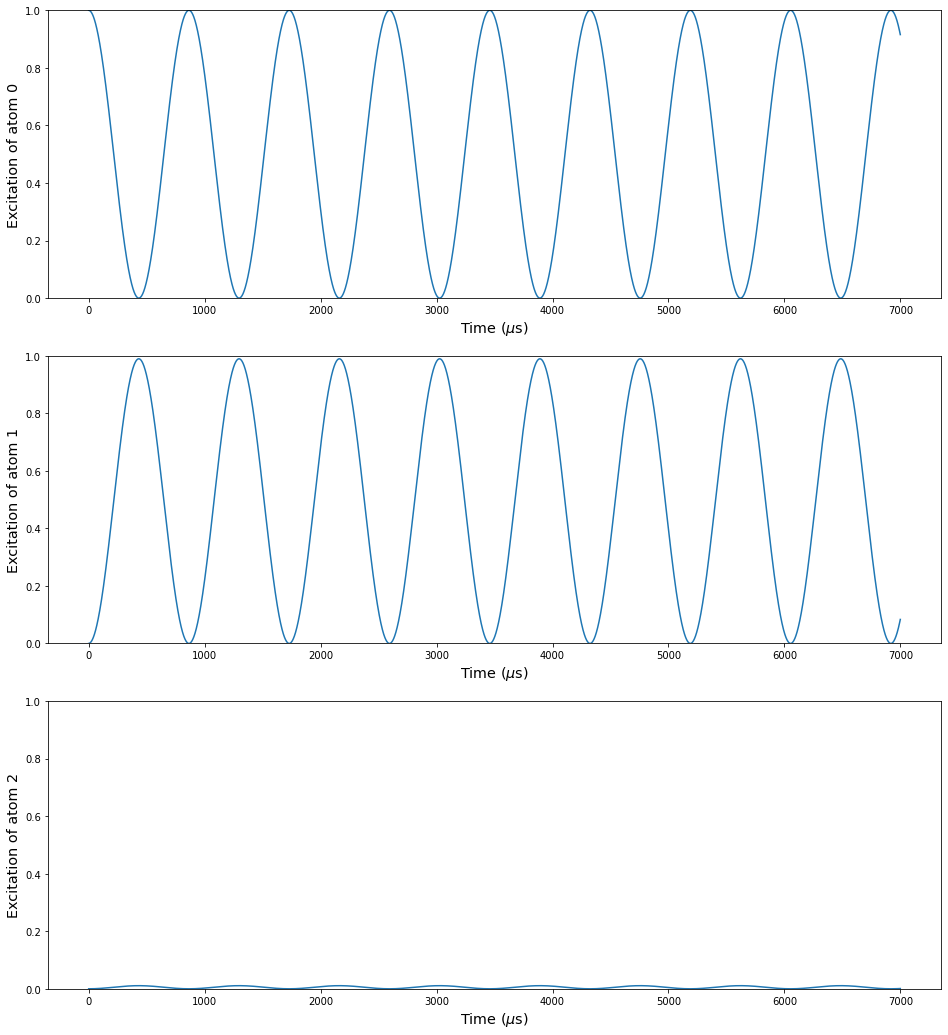

In [9]:
magn_list = [magnetization(j, 3) for j in range(3)]

expectations = results.expect(magn_list)

plt.figure(figsize=[16, 18])
plt.subplot(311)
plt.plot(expectations[0])
plt.ylabel('Excitation of atom 0', fontsize='x-large')
plt.xlabel('Time ($\mu$s)', fontsize='x-large')
plt.ylim([0, 1])
plt.subplot(312)
plt.plot(expectations[1])
plt.ylabel('Excitation of atom 1', fontsize='x-large')
plt.xlabel('Time ($\mu$s)', fontsize='x-large')
plt.ylim([0, 1])
plt.subplot(313)
plt.plot(expectations[2])
plt.ylabel('Excitation of atom 2', fontsize='x-large')
plt.xlabel('Time ($\mu$s)', fontsize='x-large')
plt.ylim([0, 1])

We can see there that there is almost no excitation in the qubit 2. It still remains some because the interaction between the qubits 0 and 2 is not completely negligible.